In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2023-11-10 10:49:43.239127: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 10:49:43.268973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 10:49:43.269007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 10:49:43.269028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 10:49:43.274721: I tensorflow/core/platform/cpu_feature_g

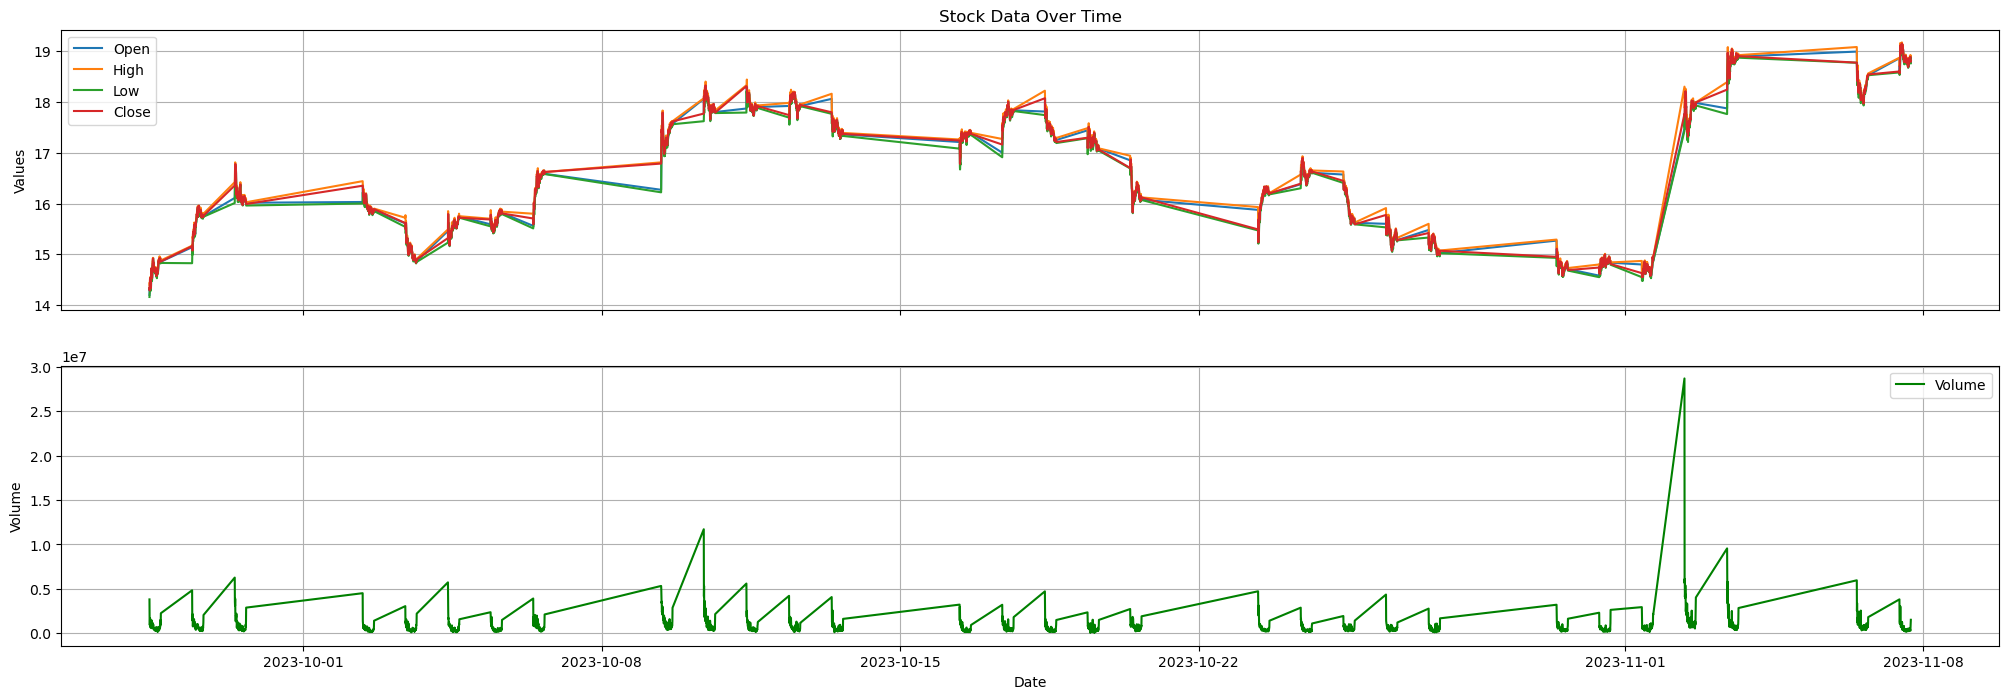

In [6]:
file_path = 'data/PLTR.csv'
target_column_name = 'Close'

pltr = pd.read_csv(file_path, index_col=0, parse_dates=True)
pltr.dropna(inplace=True)
pltr = pltr.drop('Adj Close', axis=1)
fig, ax = plt.subplots(2, 1, figsize=(25, 8), sharex=True)

ax[0].plot(pltr['Open'], label='Open')
ax[0].plot(pltr['High'], label='High')
ax[0].plot(pltr['Low'], label='Low')
ax[0].plot(pltr['Close'], label='Close')
# ax[0].plot(pltr['Adj Close'], label='Adj Close')
ax[0].set_title('Stock Data Over Time')
ax[0].set_ylabel('Values')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(pltr['Volume'], label='Volume', color='green')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume')
ax[1].legend()
ax[1].grid(True)

plt.show()

### Data refactoring
As input data we will use all the timeseries considering the previous 17 entries and using that we will try to predict all the next entries in the 18th day.

For data manipulation is wise to normalize and we are able to use a single scaler as the input and the output data have the same format.

You can test the correctess of the data refactoring uncomenting the code in the end.


In [7]:
data = pltr.copy()
data_array = np.array(data)

# Normalize the data
scaler = MinMaxScaler()
data_array = scaler.fit_transform(data_array)

# Create sequences for all targets
SEQUENCE_LENGTH = 9

def create_sequences(data, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(data[i])
    return np.array(sequence_data), np.array(sequence_target)

data_sequences, target_sequences = create_sequences(data_array, SEQUENCE_LENGTH)

# Split the data
train_size = int(len(data_array) * 0.80)

train_data, test_data = data_sequences[:train_size], data_sequences[train_size:]
train_target, test_target = target_sequences[:train_size], target_sequences[train_size:]

############################################################################################################
# 
# SEQUENCE TEST:
#   compare the data with the one inside the csv: you will notice that:
#   - we are using 17 entries as input
#   - we are forecasting (target) the 18th entry of "target_column"
############################################################################################################

# test_index = -1
# column_index = 5

# a = scaler.inverse_transform(data_sequences[test_index])
# b = scaler.inverse_transform(target_sequences)

# print(f"Values for the [{test_index}] prediction:")
# for i in range (0, 17):
#     print(f"\tdata[{i}]: {a[i][column_index]}")

# print(f'\n\ttarget: {b[test_index][column_index]}')

## Correct

In [8]:
############################################################################################################
#
# Model Definition
#
############################################################################################################

def build_single_output_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(90, input_shape=(train_data.shape[1], train_data.shape[2]), return_sequences=False))
    model.add(keras.layers.Dense(units=1))
    return model

def train_single_output_model(model, train_data, train_target, epochs=30, batch_size=256):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_data, train_target, epochs=epochs, batch_size=batch_size, verbose=2)

############################################################################################################
#
# Model Generation & Training
#
############################################################################################################
epochs = 30
batch_size = 32

models = []
for i in range(train_target.shape[1]):
    print(f"Training model for {pltr.columns[i]}")
    model = build_single_output_model(train_data.shape[1:])
    train_single_output_model(model, train_data, train_target[:, i], epochs=epochs, batch_size=batch_size)
    models.append(model)

Training model for Open


2023-11-10 10:51:05.065748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 10:51:05.096774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 10:51:05.097333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/30


2023-11-10 10:51:06.630734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-10 10:51:07.148545: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faf58102dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 10:51:07.148573: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2023-11-10 10:51:07.152202: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 10:51:07.233924: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 - 2s - loss: 0.0128 - 2s/epoch - 28ms/step
Epoch 2/30
59/59 - 0s - loss: 4.6821e-04 - 108ms/epoch - 2ms/step
Epoch 3/30
59/59 - 0s - loss: 4.2765e-04 - 105ms/epoch - 2ms/step
Epoch 4/30
59/59 - 0s - loss: 4.1681e-04 - 108ms/epoch - 2ms/step
Epoch 5/30
59/59 - 0s - loss: 3.9615e-04 - 106ms/epoch - 2ms/step
Epoch 6/30
59/59 - 0s - loss: 3.8834e-04 - 106ms/epoch - 2ms/step
Epoch 7/30
59/59 - 0s - loss: 3.8384e-04 - 109ms/epoch - 2ms/step
Epoch 8/30
59/59 - 0s - loss: 3.6321e-04 - 109ms/epoch - 2ms/step
Epoch 9/30
59/59 - 0s - loss: 3.5503e-04 - 152ms/epoch - 3ms/step
Epoch 10/30
59/59 - 0s - loss: 3.5321e-04 - 136ms/epoch - 2ms/step
Epoch 11/30
59/59 - 0s - loss: 3.3150e-04 - 130ms/epoch - 2ms/step
Epoch 12/30
59/59 - 0s - loss: 3.1611e-04 - 123ms/epoch - 2ms/step
Epoch 13/30
59/59 - 0s - loss: 3.2497e-04 - 120ms/epoch - 2ms/step
Epoch 14/30
59/59 - 0s - loss: 2.9741e-04 - 119ms/epoch - 2ms/step
Epoch 15/30
59/59 - 0s - loss: 2.8720e-04 - 106ms/epoch - 2ms/step
Epoch 16/30
59/59 - 0

15/15 [==============================] - 0s 922us/step


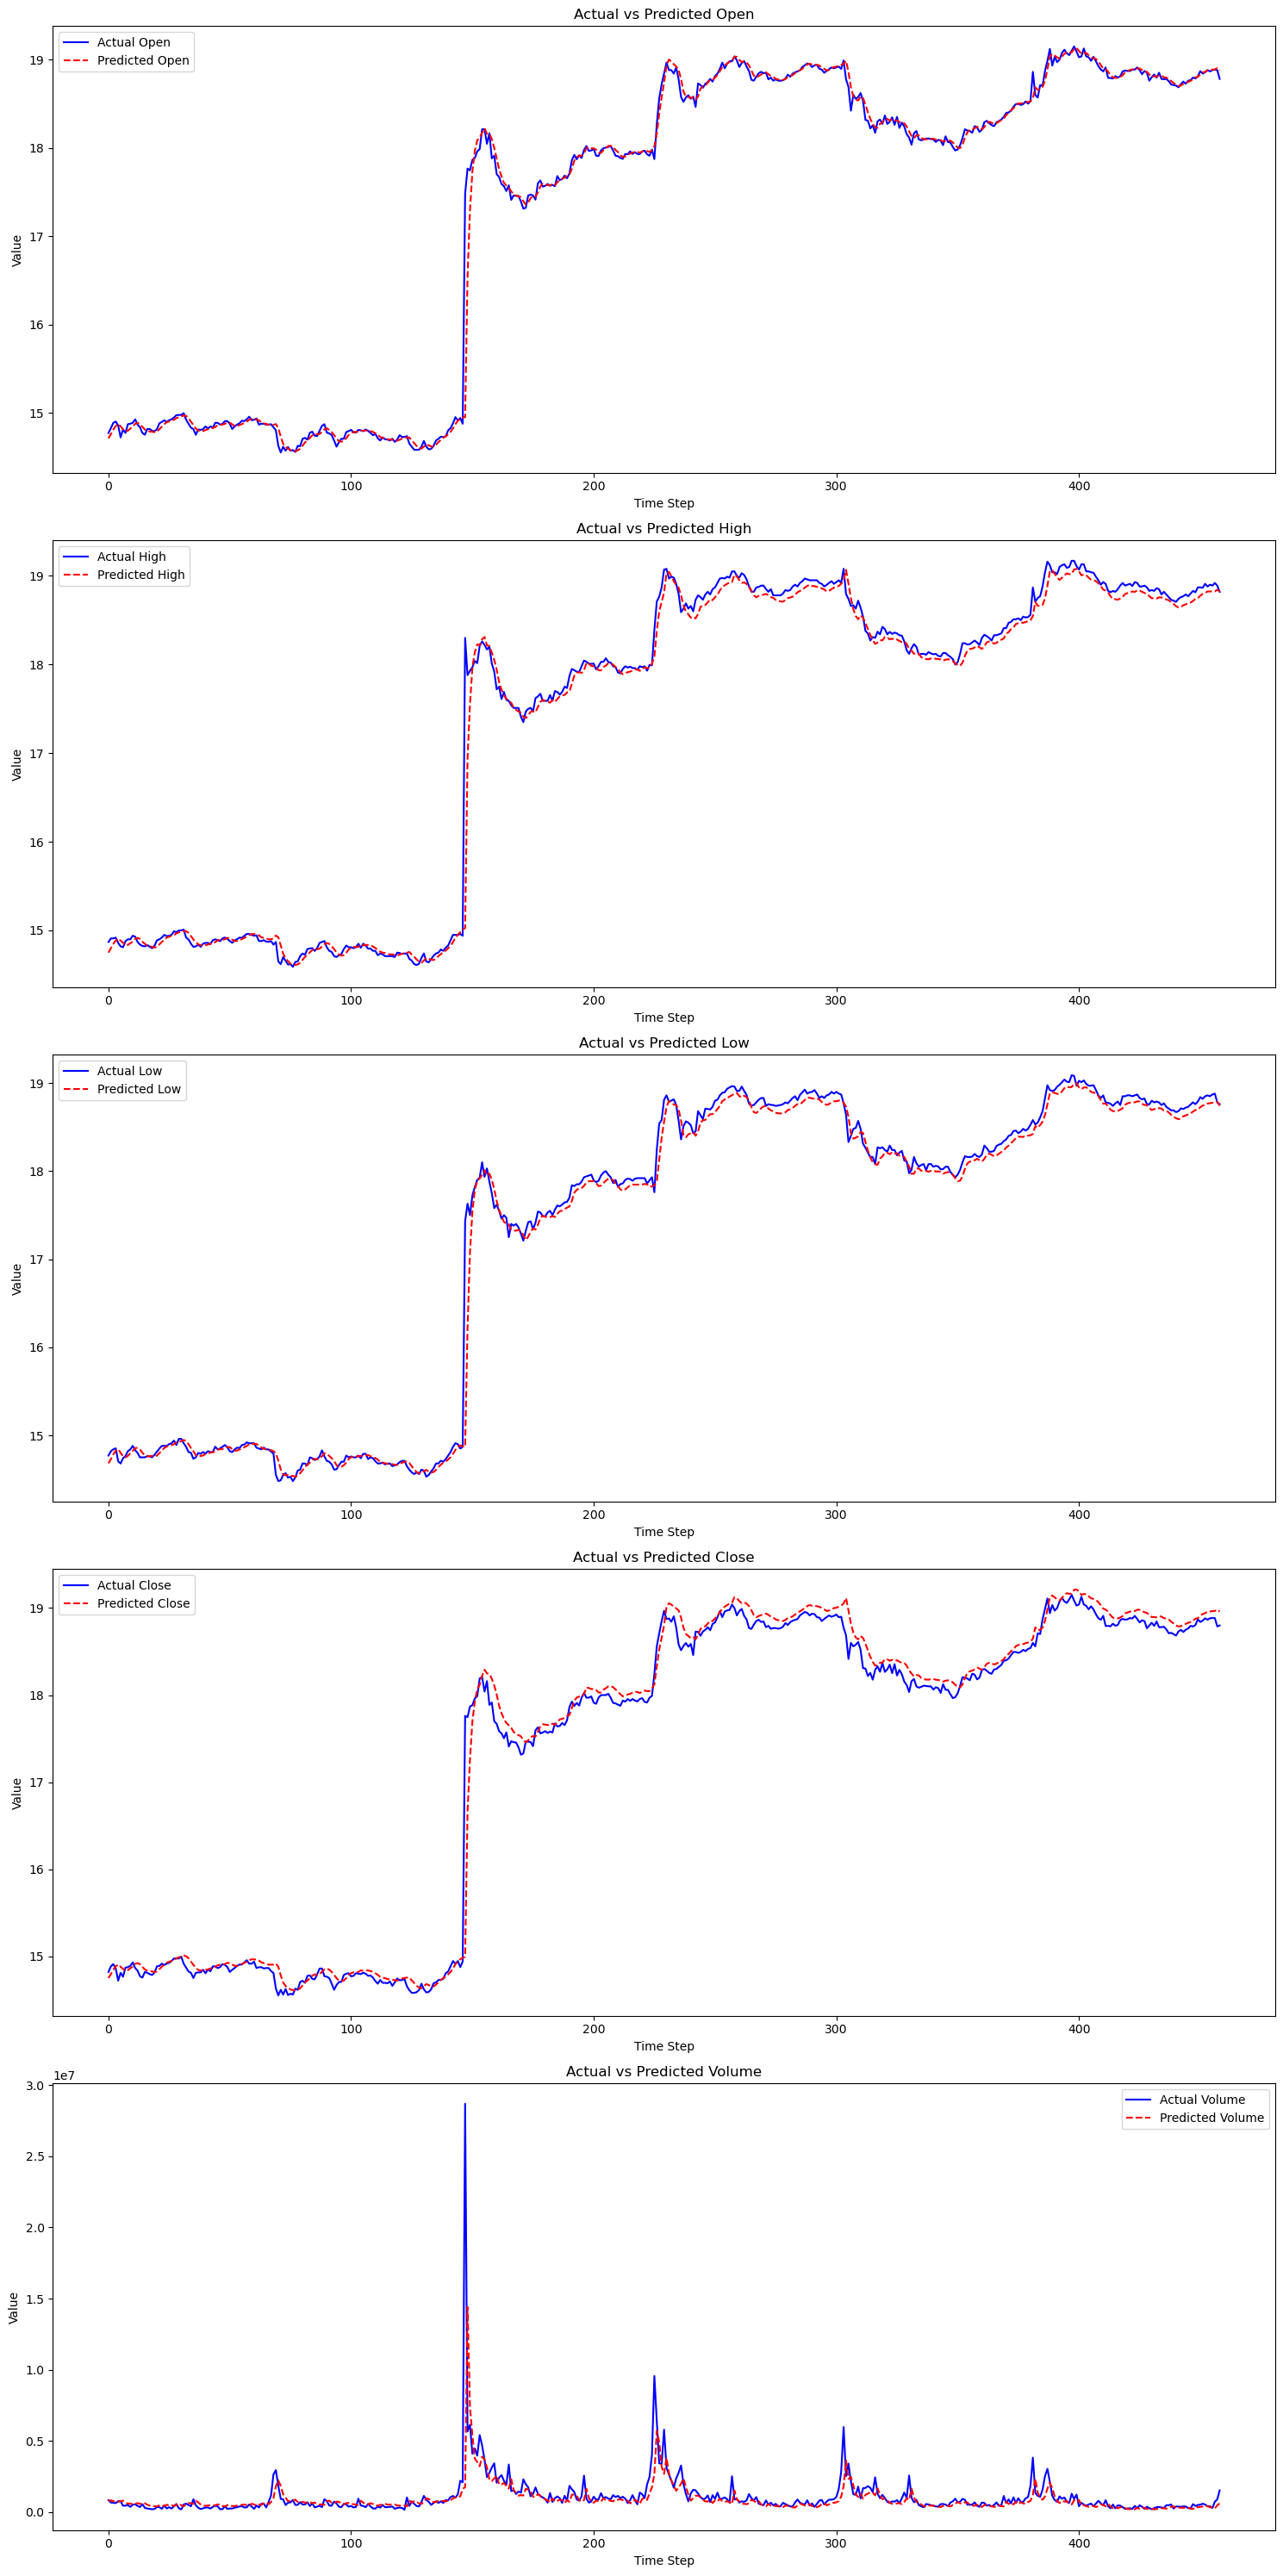

In [10]:
predicted = []
for i, model in enumerate(models):
    predicted.append(model.predict(test_data))

predicted = scaler.inverse_transform(np.column_stack(predicted))  # Combining predictions from all models
actual = scaler.inverse_transform(test_target)

# Plotting Results
num_columns = len(pltr.columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(15, 6 * num_columns))

for i, col in enumerate(pltr.columns):
    ax = axes[i] if num_columns > 1 else axes
    ax.plot(actual[:, i], label=f"Actual {col}", linestyle='solid', color='blue')
    ax.plot(predicted[:, i], label=f"Predicted {col}", linestyle='dashed', color='red')
    ax.set_title(f"Actual vs Predicted {col}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
path = './models/multi_output'
model.save(f'{path}/multi_output_model.h5')


In [ ]:

loaded_model = keras.models.load_model(f'{path}/multi_output_model.h5')